## Домашнее задание
1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого).

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки
https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/<br>
https://en.wikipedia.org/wiki/Receiver_operating_characteristic<br>
https://habr.com/ru/company/ods/blog/336168/<br>

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_roc_curve(y_test, y_score):
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

In [3]:
results = pd.DataFrame()
results['Model'] = []
results['Precision'] = []
results['Recall'] = []
results['F-Score'] = []
results['ROC_AUC'] = []

In [4]:
train_data = pd.read_csv('train_case2.csv', ';')
print(train_data.shape)
train_data.head(3)

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
for feat in ['gender','cholesterol','gluc','smoke','alco','active','cardio']:
    display(train_data[feat].value_counts())

1    45530
2    24470
Name: gender, dtype: int64

1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64

1    59479
3     5331
2     5190
Name: gluc, dtype: int64

0    63831
1     6169
Name: smoke, dtype: int64

0    66236
1     3764
Name: alco, dtype: int64

1    56261
0    13739
Name: active, dtype: int64

0    35021
1    34979
Name: cardio, dtype: int64

* gender, cholesterol, gluc - категориальные - обработаем
* age, height, weight, ap_hi, ap_lo - номинативные - масштабируем
* остальные бинарные оставим как есть

In [7]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('cardio', 1), 
                                                    train_data['cardio'], random_state=0)

In [8]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [9]:
cat_features = ['gender', 'cholesterol', 'gluc']
num_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
other_features = ['smoke', 'alco', 'active']

cat_transformers = []
num_transformers = []
other_transformers = []

for feat in cat_features:
    transformer = Pipeline([
                ('selector', ColumnSelector(key=feat)),
                ('ohe', OHEEncoder(key=feat))
            ])
    cat_transformers.append((feat, transformer))

for feat in num_features:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=feat)),
                ('standard', StandardScaler())
            ])
    num_transformers.append((feat, transfomer))
    
for feat in other_features:
    transformer = Pipeline([
                ('selector', NumberSelector(key=feat))
            ])
    other_transformers.append((feat, transformer))

In [10]:
#Объединение всех "кубиков"
feats = FeatureUnion(cat_transformers + num_transformers + other_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.]])

In [11]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [12]:
%%time
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=20, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7869387400148361
CPU times: user 10.8 s, sys: 290 ms, total: 11.1 s
Wall time: 6.91 s


In [13]:
# Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог
b=1

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, y_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc))

Best Threshold=0.386124, F-Score=0.730, Precision=0.647, Recall=0.838, ROC_AUC=0.784


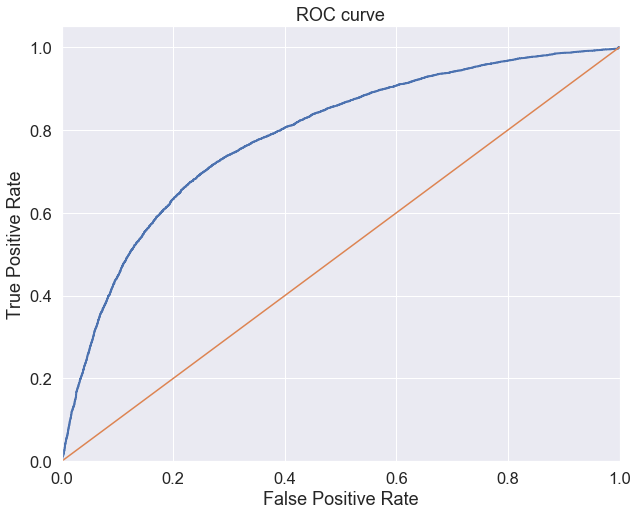

In [14]:
plot_roc_curve(y_test, y_score)

In [15]:
results = results.append({'Model': 'LogisticRegression', 
                'Precision': precision[ix],
                'Recall': recall[ix],
                'F-Score': fscore[ix],
                'ROC_AUC': roc_auc},
                ignore_index=True)
results

,Model,Precision,Recall,F-Score,ROC_AUC
0,LogisticRegression,0.647184,0.838134,0.730385,0.784207


In [16]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 42, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')),
])

In [17]:
%%time
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=20, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7975861712283577
CPU times: user 5min 19s, sys: 3.75 s, total: 5min 23s
Wall time: 1min 47s


In [18]:
# Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог
b=1

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, y_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc))

Best Threshold=0.334316, F-Score=0.737, Precision=0.656, Recall=0.842, ROC_AUC=0.798


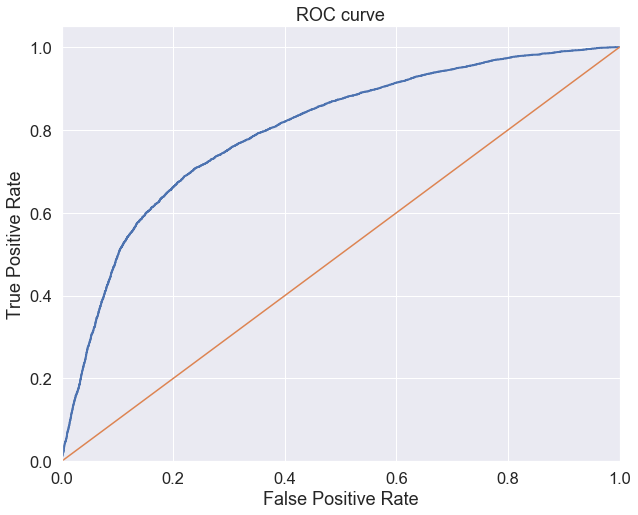

In [19]:
plot_roc_curve(y_test, y_score)

In [20]:
results = results.append({'Model': 'XGBClassifier', 
                'Precision': precision[ix],
                'Recall': recall[ix],
                'F-Score': fscore[ix],
                'ROC_AUC': roc_auc},
                ignore_index=True)
results

,Model,Precision,Recall,F-Score,ROC_AUC
0,LogisticRegression,0.647184,0.838134,0.730385,0.784207
1,XGBClassifier,0.656014,0.841935,0.737437,0.797728


In [21]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', lgb.LGBMClassifier(random_state = 42)),
])

In [22]:
%%time
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=20, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.8022127632581773
CPU times: user 41.2 s, sys: 810 ms, total: 42 s
Wall time: 14 s


In [23]:
# Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог
b=1

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, y_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc))

Best Threshold=0.340817, F-Score=0.740, Precision=0.660, Recall=0.843, ROC_AUC=0.802


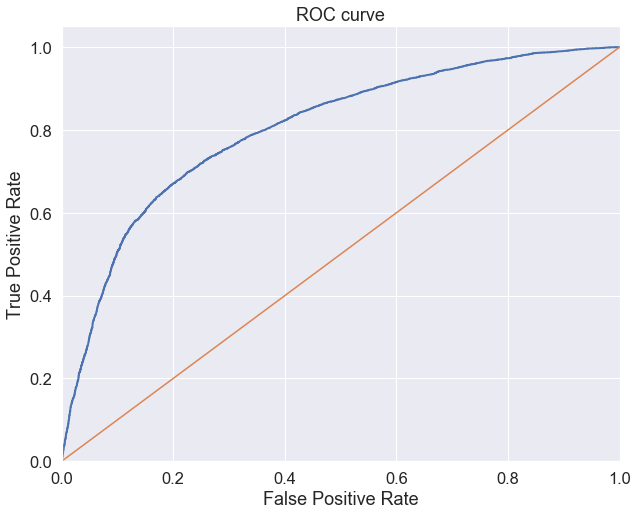

In [24]:
plot_roc_curve(y_test, y_score)

In [25]:
results = results.append({'Model': 'LGBMClassifier', 
                'Precision': precision[ix],
                'Recall': recall[ix],
                'F-Score': fscore[ix],
                'ROC_AUC': roc_auc},
                ignore_index=True)
results

,Model,Precision,Recall,F-Score,ROC_AUC
0,LogisticRegression,0.647184,0.838134,0.730385,0.784207
1,XGBClassifier,0.656014,0.841935,0.737437,0.797728
2,LGBMClassifier,0.659843,0.842972,0.740250,0.801971


In [26]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=5, random_state = 42)),
])

In [27]:
%%time
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=20, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7964910421442652
CPU times: user 51.8 s, sys: 499 ms, total: 52.3 s
Wall time: 53.9 s


In [28]:
# Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог
b=1

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, y_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc))

Best Threshold=0.385241, F-Score=0.739, Precision=0.669, Recall=0.826, ROC_AUC=0.798


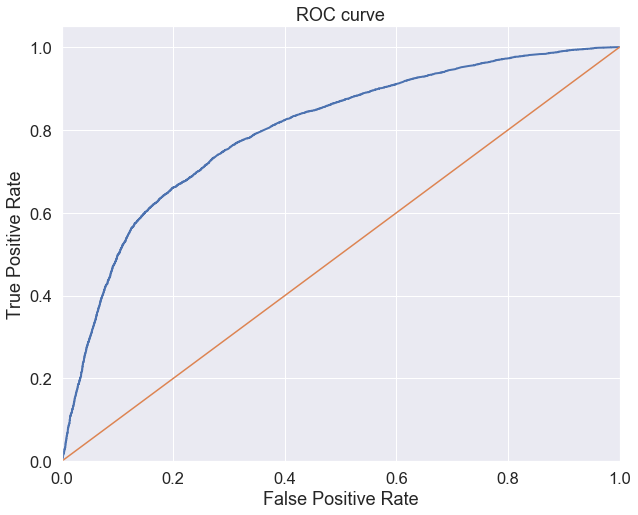

In [29]:
plot_roc_curve(y_test, y_score)

In [30]:
results = results.append({'Model': 'RandomForestClassifier', 
                'Precision': precision[ix],
                'Recall': recall[ix],
                'F-Score': fscore[ix],
                'ROC_AUC': roc_auc},
                ignore_index=True)

In [31]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', AdaBoostClassifier(n_estimators=150, random_state = 42)),
])

In [32]:
%%time
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=20, scoring='roc_auc')
cv_score = np.mean(cv_scores)
print('CV score is {}'.format(cv_score))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7961172426818391
CPU times: user 3min 58s, sys: 1.59 s, total: 4min
Wall time: 2min 6s


In [33]:
# Воспользуемся доступным в sklearn инструментарием, чтобы получить оптимальный порог
b=1

precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, y_score)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, ROC_AUC=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix],
                                                                        roc_auc))

Best Threshold=0.499079, F-Score=0.738, Precision=0.684, Recall=0.800, ROC_AUC=0.795


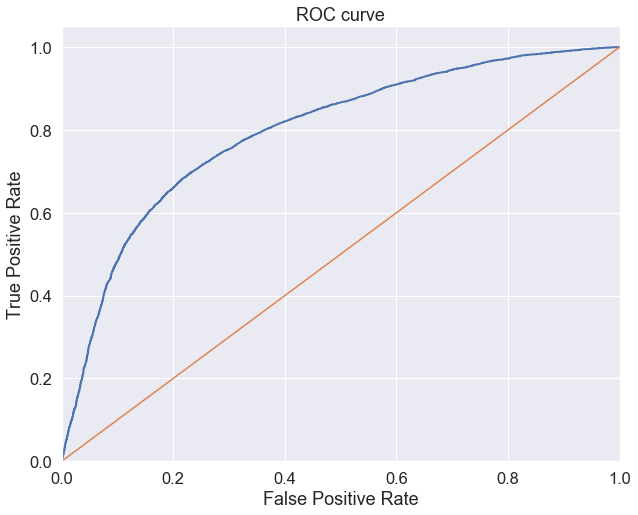

In [34]:
plot_roc_curve(y_test, y_score)

In [35]:
results = results.append({'Model': 'AdaBoostClassifier', 
                'Precision': precision[ix],
                'Recall': recall[ix],
                'F-Score': fscore[ix],
                'ROC_AUC': roc_auc},
                ignore_index=True)

In [36]:
results.sort_values(['F-Score'], ascending=False)

,Model,Precision,Recall,F-Score,ROC_AUC
2,LGBMClassifier,0.659843,0.842972,0.740250,0.801971
3,RandomForestClassifier,0.668969,0.825806,0.739160,0.797695
4,AdaBoostClassifier,0.683998,0.800230,0.737563,0.795058
1,XGBClassifier,0.656014,0.841935,0.737437,0.797728
0,LogisticRegression,0.647184,0.838134,0.730385,0.784207


Лучшее качество и по f-score и по roc_auc показала модель LightGBM.